In [1]:
from functools import partial

from transformers import CLIPVisionModel 
import torch
from torch import nn
from torchvision import transforms

from PIL import Image
import os
proxy = ""
os.environ['http_proxy'] = proxy
os.environ['https_proxy'] = proxy
# import subprocess
# import os

# result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
# output = result.stdout
# for line in output.splitlines():
#     if '=' in line:
#         var, value = line.split('=', 1)
#         os.environ[var] = value
import torch
import torch.nn as nn
from transformers import CLIPVisionModel
from torchvision import transforms
import sys
sys.path.append("../")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import transformers
print(transformers.__version__)
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

4.55.0


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import clip
from torch.nn import functional as F
import torch.nn as nn
from torchvision import transforms
from PIL import Image
train = False
classes = None
pictures= None

def load_data():
    data_list = []
    label_list = []
    texts = []
    images = []
    
    if train:
        text_directory = "/ibex/user/thagafhh/data/training_images"
    else:
        text_directory = "/ibex/user/thagafhh/data/test_images"
    dirnames = [d for d in os.listdir(text_directory) if os.path.isdir(os.path.join(text_directory, d))]
    dirnames.sort()
    
    if classes is not None:
        dirnames = [dirnames[i] for i in classes]

    for dir in dirnames:

        try:
            idx = dir.index('_')
            description = dir[idx+1:]
        except ValueError:
            print(f"Skipped: {dir} due to no '_' found.")
            continue
            
        new_description = f"{description}"
        texts.append(new_description)

    if train:
        img_directory = "/ibex/user/thagafhh/data/training_images"
    else:
        img_directory ="/ibex/user/thagafhh/data/test_images"
    
    all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]
    all_folders.sort()

    if classes is not None and pictures is not None:
        images = []
        for i in range(len(classes)):
            class_idx = classes[i]
            pic_idx = pictures[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                if pic_idx < len(all_images):
                    images.append(os.path.join(folder_path, all_images[pic_idx]))
    elif classes is not None and pictures is None:
        images = []
        for i in range(len(classes)):
            class_idx = classes[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                images.extend(os.path.join(folder_path, img) for img in all_images)
    elif classes is None:
        images = []
        for folder in all_folders:
            folder_path = os.path.join(img_directory, folder)
            all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_images.sort()  
            images.extend(os.path.join(folder_path, img) for img in all_images)
    else:

        print("Error")
    return texts, images
texts, images = load_data()

texts
# images

['aircraft_carrier',
 'antelope',
 'backscratcher',
 'balance_beam',
 'banana',
 'baseball_bat',
 'basil',
 'basketball',
 'bassoon',
 'baton4',
 'batter',
 'beaver',
 'bench',
 'bike',
 'birthday_cake',
 'blowtorch',
 'boat',
 'bok_choy',
 'bonnet',
 'bottle_opener',
 'brace',
 'bread',
 'breadbox',
 'bug',
 'buggy',
 'bullet',
 'bun',
 'bush',
 'calamari',
 'candlestick',
 'cart',
 'cashew',
 'cat',
 'caterpillar',
 'cd_player',
 'chain',
 'chaps',
 'cheese',
 'cheetah',
 'chest2',
 'chime',
 'chopsticks',
 'cleat',
 'cleaver',
 'coat',
 'cobra',
 'coconut',
 'coffee_bean',
 'coffeemaker',
 'cookie',
 'cordon_bleu',
 'coverall',
 'crab',
 'creme_brulee',
 'crepe',
 'crib',
 'croissant',
 'crow',
 'cruise_ship',
 'crumb',
 'cupcake',
 'dagger',
 'dalmatian',
 'dessert',
 'dragonfly',
 'dreidel',
 'drum',
 'duffel_bag',
 'eagle',
 'eel',
 'egg',
 'elephant',
 'espresso',
 'face_mask',
 'ferry',
 'flamingo',
 'folder',
 'fork',
 'freezer',
 'french_horn',
 'fruit',
 'garlic',
 'glove',


In [4]:
class CLIPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.clip = CLIPVisionModel.from_pretrained('openai/clip-vit-large-patch14').to(torch.bfloat16)
        # self.clip_size = (224, 224)

        self.preprocess = CLIPImageProcessor(
            size={"height": 512, "width": 512},
            crop_size={"height": 512, "width": 512},
        )


        # for param in self.clip.parameters():
        #     param.requires_grad = False
        self.image_encoder = CLIPVisionModelWithProjection.from_pretrained(
        "h94/IP-Adapter", 
        # "laion2b_s32b_b79k",
        subfolder="models/image_encoder",
        torch_dtype=torch.float16,
        ).to("cuda")
        
        
    
def encode_image(image, image_encoder, feature_extractor, num_images_per_prompt=1, device='cuda'):
    dtype = next(image_encoder.parameters()).dtype

    if not isinstance(image, torch.Tensor):
        image = feature_extractor(image, return_tensors="pt").pixel_values # [1, 3, 224, 224]
        print("image", image.shape)
    image = image.to(device=device, dtype=dtype)
    image_embeds = image_encoder(image).image_embeds # (1, 1024)
    image_embeds = image_embeds.repeat_interleave(num_images_per_prompt, dim=0) # (num_images_per_prompt, 1024)

    return image_embeds

clip_encoder = CLIPEncoder().to(device)


In [5]:
print(device)

cuda


In [ ]:
numpy.load('/ibex/user/thagafhh/data/amjad_stuff/best1/sub-01_test_embeds.npy')

In [30]:
# image = Image.open(example_image_path).convert("RGB")
# image_embeds = encode_image(image_prompt, clip_encoder.image_encoder, clip_encoder.preprocess, 1, device)
# image_embeds.shape

In [31]:
import torch
# torch.save(image_embeds, 'image_embeds.pt')
image_embeds = torch.load('/ibex/user/thagafhh/data/ViT-H-14_features_test.pt', map_location=device)['img_features'].unsqueeze(1)
image_embeds_dreamsim = torch.load('/ibex/user/thagafhh/data/dreamsim_features_test.pt', map_location=device)['img_features'].unsqueeze(1)
eeg_embeds = torch.load('/ibex/user/thagafhh/data/eeg_data/ATM_S_eeg_features_sub-08_test.pt', map_location=device).unsqueeze(1)
old_eeg = torch.load('/ibex/user/thagafhh/data/emb_eeg/ATM_S_eeg_features_sub-08_test.pt', map_location=device).unsqueeze(1)


print(image_embeds.shape, image_embeds_dreamsim.shape, eeg_embeds.shape, old_eeg.shape)

torch.Size([200, 1, 1024]) torch.Size([200, 1, 1792]) torch.Size([200, 1, 1792]) torch.Size([200, 1, 1024])


In [32]:
# img_feature = img_feature.mean(dim=1).squeeze(0)
# img_feature = img_feature.unsqueeze(0)
# img_feature.shape

In [10]:
# open_clip_img_feature = torch.load('ViT-H-14_features_test.pt', map_location=device)['img_features'].unsqueeze(1)
# open_clip_img_feature[0].shape

In [11]:
# open_clip_img_feature[0].std()

In [12]:
# import torch
# image_features_test = torch.load("/home/ldy/Workspace/EEG_caption/ViT-H-14_features_test.pt")
# image_features_test['img_features'].shape

In [13]:
# image_features_test['img_features'][0].unsqueeze(0).shape

In [14]:
# import torch
# image_features_test = torch.load("/home/ldy/Workspace/BrainAligning/ViT-L-14_features_multimodal_test.pt")
# image_features_test['img_features'].shape

In [6]:
import sys
import os

# Define the root path of your project
project_root = '/home/thagafhh/work/EEG_Image_decode/Generation' 

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

    
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# import open_clip
from matplotlib.font_manager import FontProperties


from diffusion_prior import *
from custom_pipeline_low_level import *
# from custom_pipeline import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/home/thagafhh/work/.venv/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


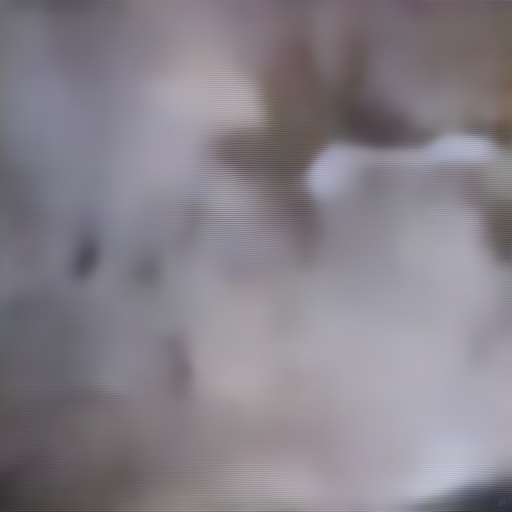

torch.Size([1, 3, 512, 512])

In [21]:
from PIL import Image
index = 65
low_level_img_path = f'/root/autodl-tmp/BrainAligning/vae_imgs/epoch_170/reconstructed_image_{index}_20.png'
# Provides low-level images 
low_level_image = Image.open(low_level_img_path)
low_level_image.show()
low_level_image = clip_encoder.preprocess(low_level_image, return_tensors="pt").pixel_values # [1, 3, 224, 224]
low_level_image.shape

In [ ]:
from diffusers.image_processor import VaeImageProcessor
image_processor = VaeImageProcessor()
from diffusers import AutoencoderKL
# path = "stabilityai/sdxl-turbo"
# vlmodel = AutoencoderKL.from_pretrained(
#     path, subfolder='vae').to(device)

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float, variant="fp16")
vlmodel = pipe.vae

posterior = vlmodel.encode(low_level_image).latent_dist
image_latent = posterior.mode()
print("image_latent.shape", image_latent.shape)

In [7]:
#generator setup
generator = Generator4Embeds(num_inference_steps=4, device=device)
# set a seed value
seed_value = 42
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/thagafhh/work/.venv/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# diffusion_prior = DiffusionPriorUNet(cond_dim=1792, dropout=0.1)

# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)
# load pretrained model
pipe.diffusion_prior.load_state_dict(torch.load(f'/ibex/user/thagafhh/data/fintune_ckpts/sub-08/diffusion_prior.pt', map_location=device))

9675648


<All keys matched successfully>

In [12]:
import torch
# torch.save(image_embeds, 'image_embeds.pt')
image_embeds = torch.load('/ibex/user/thagafhh/data/ViT-H-14_features_test.pt', map_location=device)['img_features'].unsqueeze(1)
# eeg_embeds = torch.load('/ibex/user/thagafhh/data/eeg_data/ATM_S_eeg_features_sub-08_dreamsim_test.pt', map_location=device).unsqueeze(1)
eeg_embeds = torch.load('/ibex/user/thagafhh/data/emb_eeg/ATM_S_eeg_features_sub-08_test.pt', map_location=device).unsqueeze(1)


print(image_embeds.shape, eeg_embeds.shape)

torch.Size([200, 1, 1024]) torch.Size([200, 1, 1024])


In [90]:
import os
from PIL import Image
from tqdm.notebook import tqdm # Use notebook-friendly tqdm for a nice progress bar

# --- 1. Setup the Output Directory ---
# Define the name of the directory where images will be saved.
output_dir = "/ibex/user/thagafhh/data/reconstruction_results/abdulaziz"

# Create the directory. `exist_ok=True` prevents an error if the directory already exists.
os.makedirs(output_dir, exist_ok=True)
print(f"Images will be saved in the '{output_dir}/' directory.")

# --- 2. The Main Generation and Saving Loop ---
# We use tqdm to wrap the range for a progress bar.
for index in tqdm(range(len(images)), desc="Generating and Saving Images"):
    
    # --- A. Ground Truth Image ---
    try:
        # Load the ground truth image from its path
        gt_image_path = images[index]
        gt_image = Image.open(gt_image_path)
        
        # Define a descriptive filename
        gt_filename = f"sample_{texts[index]}_ground_truth.png"
        gt_save_path = os.path.join(output_dir, gt_filename)
        
        # Save the image
        gt_image.save(gt_save_path)
        print(f"Saved: {gt_save_path}")

    except Exception as e:
        print(f"Could not save ground truth for index {index}. Error: {e}")

    # --- B. Reconstruction with NEW Embeddings ---
    try:
        # Generate the high-level features from your new EEG embeddings
        high_level_features_new = pipe.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)
        
        # Generate the final image
        image_new = generator.generate(high_level_features_new, generator=gen)
        
        # Define a descriptive filename
        new_filename = f"sample_{texts[index]}_reconstruction_new.png"
        new_save_path = os.path.join(output_dir, new_filename)
        
        # Save the image
        image_new.save(new_save_path)
        print(f"Saved: {new_save_path}")

    except Exception as e:
        print(f"Could not generate/save 'new' reconstruction for index {index}. Error: {e}")

    # --- C. Reconstruction with OLD Embeddings ---
    try:
        # Generate the high-level features from the paper's old EEG embeddings
        high_level_features_old = pipe.generate(c_embeds=old_eeg[index], num_inference_steps=10, guidance_scale=2.0)
        
        # Generate the final image
        image_old = generator.generate(high_level_features_old, generator=gen)
        
        # Define a descriptive filename
        old_filename = f"sample_{texts[index]}_reconstruction_old.png"
        old_save_path = os.path.join(output_dir, old_filename)
        
        # Save the image
        image_old.save(old_save_path)
        print(f"Saved: {old_save_path}")

    except Exception as e:
        print(f"Could not generate/save 'old' reconstruction for index {index}. Error: {e}")

print("\n--- All images have been generated and saved. ---")

Images will be saved in the '/ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/' directory.


Generating and Saving Images:   0%|          | 0/200 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_aircraft_carrier_ground_truth.png



10it [00:00, 190.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_aircraft_carrier_reconstruction_new.png



10it [00:00, 195.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_aircraft_carrier_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_antelope_ground_truth.png



10it [00:00, 192.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_antelope_reconstruction_new.png



10it [00:00, 197.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_antelope_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_backscratcher_ground_truth.png



10it [00:00, 207.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_backscratcher_reconstruction_new.png



10it [00:00, 204.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_backscratcher_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_balance_beam_ground_truth.png



10it [00:00, 199.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_balance_beam_reconstruction_new.png



10it [00:00, 205.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_balance_beam_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_banana_ground_truth.png



10it [00:00, 200.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_banana_reconstruction_new.png



10it [00:00, 202.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_banana_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_baseball_bat_ground_truth.png



10it [00:00, 202.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_baseball_bat_reconstruction_new.png



10it [00:00, 202.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_baseball_bat_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_basil_ground_truth.png



10it [00:00, 202.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_basil_reconstruction_new.png



10it [00:00, 205.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_basil_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_basketball_ground_truth.png



10it [00:00, 204.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_basketball_reconstruction_new.png



10it [00:00, 204.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_basketball_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bassoon_ground_truth.png



10it [00:00, 207.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bassoon_reconstruction_new.png



10it [00:00, 200.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bassoon_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_baton4_ground_truth.png



10it [00:00, 203.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_baton4_reconstruction_new.png



10it [00:00, 206.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_baton4_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_batter_ground_truth.png



10it [00:00, 205.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_batter_reconstruction_new.png



10it [00:00, 203.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_batter_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_beaver_ground_truth.png



10it [00:00, 202.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_beaver_reconstruction_new.png



10it [00:00, 205.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_beaver_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bench_ground_truth.png



10it [00:00, 205.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bench_reconstruction_new.png



10it [00:00, 208.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bench_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bike_ground_truth.png



10it [00:00, 204.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bike_reconstruction_new.png



10it [00:00, 201.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bike_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_birthday_cake_ground_truth.png



10it [00:00, 204.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_birthday_cake_reconstruction_new.png



10it [00:00, 205.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_birthday_cake_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_blowtorch_ground_truth.png



10it [00:00, 201.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_blowtorch_reconstruction_new.png



10it [00:00, 204.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_blowtorch_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_boat_ground_truth.png



10it [00:00, 202.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_boat_reconstruction_new.png



10it [00:00, 201.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_boat_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bok_choy_ground_truth.png



10it [00:00, 205.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bok_choy_reconstruction_new.png



10it [00:00, 202.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bok_choy_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bonnet_ground_truth.png



10it [00:00, 201.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bonnet_reconstruction_new.png



10it [00:00, 203.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bonnet_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bottle_opener_ground_truth.png



10it [00:00, 199.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bottle_opener_reconstruction_new.png



10it [00:00, 201.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bottle_opener_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_brace_ground_truth.png



10it [00:00, 204.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_brace_reconstruction_new.png



10it [00:00, 204.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_brace_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bread_ground_truth.png



10it [00:00, 204.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bread_reconstruction_new.png



10it [00:00, 206.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bread_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_breadbox_ground_truth.png



10it [00:00, 205.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_breadbox_reconstruction_new.png



10it [00:00, 203.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_breadbox_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bug_ground_truth.png



10it [00:00, 207.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bug_reconstruction_new.png



10it [00:00, 203.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bug_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_buggy_ground_truth.png



10it [00:00, 199.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_buggy_reconstruction_new.png



10it [00:00, 206.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_buggy_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bullet_ground_truth.png



10it [00:00, 206.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bullet_reconstruction_new.png



10it [00:00, 204.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bullet_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bun_ground_truth.png



10it [00:00, 205.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bun_reconstruction_new.png



10it [00:00, 205.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bun_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bush_ground_truth.png



10it [00:00, 199.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bush_reconstruction_new.png



10it [00:00, 204.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_bush_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_calamari_ground_truth.png



10it [00:00, 202.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_calamari_reconstruction_new.png



10it [00:00, 201.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_calamari_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_candlestick_ground_truth.png



10it [00:00, 205.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_candlestick_reconstruction_new.png



10it [00:00, 203.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_candlestick_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cart_ground_truth.png



10it [00:00, 199.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cart_reconstruction_new.png



10it [00:00, 203.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cart_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cashew_ground_truth.png



10it [00:00, 202.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cashew_reconstruction_new.png



10it [00:00, 206.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cashew_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cat_ground_truth.png



10it [00:00, 204.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cat_reconstruction_new.png



10it [00:00, 204.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cat_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_caterpillar_ground_truth.png



10it [00:00, 203.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_caterpillar_reconstruction_new.png



10it [00:00, 203.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_caterpillar_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cd_player_ground_truth.png



10it [00:00, 201.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cd_player_reconstruction_new.png



10it [00:00, 202.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cd_player_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chain_ground_truth.png



10it [00:00, 202.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chain_reconstruction_new.png



10it [00:00, 202.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chain_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chaps_ground_truth.png



10it [00:00, 205.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chaps_reconstruction_new.png



10it [00:00, 204.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chaps_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cheese_ground_truth.png



10it [00:00, 202.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cheese_reconstruction_new.png



10it [00:00, 200.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cheese_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cheetah_ground_truth.png



10it [00:00, 204.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cheetah_reconstruction_new.png



10it [00:00, 202.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cheetah_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chest2_ground_truth.png



10it [00:00, 200.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chest2_reconstruction_new.png



10it [00:00, 203.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chest2_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chime_ground_truth.png



10it [00:00, 201.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chime_reconstruction_new.png



10it [00:00, 200.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chime_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chopsticks_ground_truth.png



10it [00:00, 204.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chopsticks_reconstruction_new.png



10it [00:00, 203.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_chopsticks_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cleat_ground_truth.png



10it [00:00, 201.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cleat_reconstruction_new.png



10it [00:00, 204.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cleat_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cleaver_ground_truth.png



10it [00:00, 201.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cleaver_reconstruction_new.png



10it [00:00, 203.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cleaver_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coat_ground_truth.png



10it [00:00, 206.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coat_reconstruction_new.png



10it [00:00, 202.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coat_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cobra_ground_truth.png



10it [00:00, 201.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cobra_reconstruction_new.png



10it [00:00, 203.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cobra_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coconut_ground_truth.png



10it [00:00, 202.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coconut_reconstruction_new.png



10it [00:00, 202.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coconut_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coffee_bean_ground_truth.png



10it [00:00, 201.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coffee_bean_reconstruction_new.png



10it [00:00, 200.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coffee_bean_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coffeemaker_ground_truth.png



10it [00:00, 202.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coffeemaker_reconstruction_new.png



10it [00:00, 204.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coffeemaker_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cookie_ground_truth.png



10it [00:00, 200.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cookie_reconstruction_new.png



10it [00:00, 201.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cookie_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cordon_bleu_ground_truth.png



10it [00:00, 202.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cordon_bleu_reconstruction_new.png



10it [00:00, 199.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cordon_bleu_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coverall_ground_truth.png



10it [00:00, 201.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coverall_reconstruction_new.png



10it [00:00, 199.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_coverall_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crab_ground_truth.png



10it [00:00, 203.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crab_reconstruction_new.png



10it [00:00, 203.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crab_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_creme_brulee_ground_truth.png



10it [00:00, 204.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_creme_brulee_reconstruction_new.png



10it [00:00, 202.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_creme_brulee_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crepe_ground_truth.png



10it [00:00, 201.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crepe_reconstruction_new.png



10it [00:00, 203.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crepe_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crib_ground_truth.png



10it [00:00, 201.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crib_reconstruction_new.png



10it [00:00, 202.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crib_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_croissant_ground_truth.png



10it [00:00, 200.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_croissant_reconstruction_new.png



10it [00:00, 201.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_croissant_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crow_ground_truth.png



10it [00:00, 200.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crow_reconstruction_new.png



10it [00:00, 198.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crow_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cruise_ship_ground_truth.png



10it [00:00, 196.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cruise_ship_reconstruction_new.png



10it [00:00, 198.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cruise_ship_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crumb_ground_truth.png



10it [00:00, 199.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crumb_reconstruction_new.png



10it [00:00, 202.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_crumb_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cupcake_ground_truth.png



10it [00:00, 196.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cupcake_reconstruction_new.png



10it [00:00, 201.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_cupcake_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dagger_ground_truth.png



10it [00:00, 201.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dagger_reconstruction_new.png



10it [00:00, 202.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dagger_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dalmatian_ground_truth.png



10it [00:00, 200.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dalmatian_reconstruction_new.png



10it [00:00, 201.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dalmatian_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dessert_ground_truth.png



10it [00:00, 195.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dessert_reconstruction_new.png



10it [00:00, 183.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dessert_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dragonfly_ground_truth.png



10it [00:00, 198.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dragonfly_reconstruction_new.png



10it [00:00, 200.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dragonfly_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dreidel_ground_truth.png



10it [00:00, 202.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dreidel_reconstruction_new.png



10it [00:00, 194.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_dreidel_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_drum_ground_truth.png



10it [00:00, 199.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_drum_reconstruction_new.png



10it [00:00, 198.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_drum_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_duffel_bag_ground_truth.png



10it [00:00, 198.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_duffel_bag_reconstruction_new.png



10it [00:00, 200.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_duffel_bag_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_eagle_ground_truth.png



10it [00:00, 199.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_eagle_reconstruction_new.png



10it [00:00, 196.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_eagle_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_eel_ground_truth.png



10it [00:00, 193.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_eel_reconstruction_new.png



10it [00:00, 176.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_eel_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_egg_ground_truth.png



10it [00:00, 184.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_egg_reconstruction_new.png



10it [00:00, 198.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_egg_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_elephant_ground_truth.png



10it [00:00, 197.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_elephant_reconstruction_new.png



10it [00:00, 198.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_elephant_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_espresso_ground_truth.png



10it [00:00, 199.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_espresso_reconstruction_new.png



10it [00:00, 202.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_espresso_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_face_mask_ground_truth.png



10it [00:00, 190.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_face_mask_reconstruction_new.png



10it [00:00, 182.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_face_mask_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ferry_ground_truth.png



10it [00:00, 199.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ferry_reconstruction_new.png



10it [00:00, 190.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ferry_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_flamingo_ground_truth.png



10it [00:00, 199.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_flamingo_reconstruction_new.png



10it [00:00, 200.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_flamingo_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_folder_ground_truth.png



10it [00:00, 202.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_folder_reconstruction_new.png



10it [00:00, 200.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_folder_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_fork_ground_truth.png



10it [00:00, 199.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_fork_reconstruction_new.png



10it [00:00, 197.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_fork_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_freezer_ground_truth.png



10it [00:00, 200.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_freezer_reconstruction_new.png



10it [00:00, 200.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_freezer_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_french_horn_ground_truth.png



10it [00:00, 199.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_french_horn_reconstruction_new.png



10it [00:00, 194.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_french_horn_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_fruit_ground_truth.png



10it [00:00, 197.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_fruit_reconstruction_new.png



10it [00:00, 196.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_fruit_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_garlic_ground_truth.png



10it [00:00, 195.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_garlic_reconstruction_new.png



10it [00:00, 202.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_garlic_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_glove_ground_truth.png



10it [00:00, 201.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_glove_reconstruction_new.png



10it [00:00, 195.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_glove_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_golf_cart_ground_truth.png



10it [00:00, 188.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_golf_cart_reconstruction_new.png



10it [00:00, 194.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_golf_cart_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_gondola_ground_truth.png



10it [00:00, 192.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_gondola_reconstruction_new.png



10it [00:00, 191.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_gondola_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_goose_ground_truth.png



10it [00:00, 195.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_goose_reconstruction_new.png



10it [00:00, 192.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_goose_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_gopher_ground_truth.png



10it [00:00, 195.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_gopher_reconstruction_new.png



10it [00:00, 199.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_gopher_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_gorilla_ground_truth.png



10it [00:00, 195.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_gorilla_reconstruction_new.png



10it [00:00, 195.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_gorilla_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_grasshopper_ground_truth.png



10it [00:00, 196.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_grasshopper_reconstruction_new.png



10it [00:00, 197.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_grasshopper_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_grenade_ground_truth.png



10it [00:00, 193.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_grenade_reconstruction_new.png



10it [00:00, 197.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_grenade_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hamburger_ground_truth.png



10it [00:00, 197.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hamburger_reconstruction_new.png



10it [00:00, 192.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hamburger_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hammer_ground_truth.png



10it [00:00, 199.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hammer_reconstruction_new.png



10it [00:00, 198.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hammer_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_handbrake_ground_truth.png



10it [00:00, 197.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_handbrake_reconstruction_new.png



10it [00:00, 198.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_handbrake_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_headscarf_ground_truth.png



10it [00:00, 195.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_headscarf_reconstruction_new.png



10it [00:00, 198.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_headscarf_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_highchair_ground_truth.png



0it [00:00, ?it/s]
10it [00:00, 36.49it/s][A


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_highchair_reconstruction_new.png



10it [00:00, 196.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_highchair_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hoodie_ground_truth.png



10it [00:00, 198.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hoodie_reconstruction_new.png



10it [00:00, 197.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hoodie_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hummingbird_ground_truth.png



10it [00:00, 196.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hummingbird_reconstruction_new.png



10it [00:00, 200.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_hummingbird_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ice_cube_ground_truth.png



10it [00:00, 197.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ice_cube_reconstruction_new.png



10it [00:00, 199.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ice_cube_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ice_pack_ground_truth.png



10it [00:00, 198.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ice_pack_reconstruction_new.png



10it [00:00, 201.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ice_pack_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_jeep_ground_truth.png



10it [00:00, 197.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_jeep_reconstruction_new.png



10it [00:00, 201.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_jeep_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_jelly_bean_ground_truth.png



10it [00:00, 198.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_jelly_bean_reconstruction_new.png



10it [00:00, 199.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_jelly_bean_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_jukebox_ground_truth.png



10it [00:00, 200.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_jukebox_reconstruction_new.png



10it [00:00, 199.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_jukebox_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_kettle_ground_truth.png



10it [00:00, 201.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_kettle_reconstruction_new.png



10it [00:00, 199.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_kettle_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_kneepad_ground_truth.png



10it [00:00, 200.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_kneepad_reconstruction_new.png



10it [00:00, 201.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_kneepad_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ladle_ground_truth.png



10it [00:00, 203.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ladle_reconstruction_new.png



10it [00:00, 200.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ladle_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lamb_ground_truth.png



10it [00:00, 199.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lamb_reconstruction_new.png



10it [00:00, 202.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lamb_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lampshade_ground_truth.png



10it [00:00, 200.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lampshade_reconstruction_new.png



10it [00:00, 202.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lampshade_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_laundry_basket_ground_truth.png



10it [00:00, 204.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_laundry_basket_reconstruction_new.png



10it [00:00, 202.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_laundry_basket_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lettuce_ground_truth.png



10it [00:00, 202.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lettuce_reconstruction_new.png



10it [00:00, 204.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lettuce_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lightning_bug_ground_truth.png



10it [00:00, 203.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lightning_bug_reconstruction_new.png



10it [00:00, 203.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_lightning_bug_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_manatee_ground_truth.png



10it [00:00, 201.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_manatee_reconstruction_new.png



10it [00:00, 202.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_manatee_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_marijuana_ground_truth.png



10it [00:00, 203.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_marijuana_reconstruction_new.png



10it [00:00, 202.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_marijuana_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_meatloaf_ground_truth.png



10it [00:00, 199.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_meatloaf_reconstruction_new.png



10it [00:00, 199.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_meatloaf_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_metal_detector_ground_truth.png



10it [00:00, 204.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_metal_detector_reconstruction_new.png



10it [00:00, 203.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_metal_detector_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_minivan_ground_truth.png



10it [00:00, 203.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_minivan_reconstruction_new.png



10it [00:00, 204.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_minivan_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_modem_ground_truth.png



10it [00:00, 201.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_modem_reconstruction_new.png



10it [00:00, 200.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_modem_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_mosquito_ground_truth.png



10it [00:00, 201.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_mosquito_reconstruction_new.png



10it [00:00, 199.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_mosquito_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_muff_ground_truth.png



10it [00:00, 198.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_muff_reconstruction_new.png



10it [00:00, 200.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_muff_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_music_box_ground_truth.png



10it [00:00, 199.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_music_box_reconstruction_new.png



10it [00:00, 200.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_music_box_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_mussel_ground_truth.png



10it [00:00, 199.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_mussel_reconstruction_new.png



10it [00:00, 201.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_mussel_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_nightstand_ground_truth.png



10it [00:00, 199.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_nightstand_reconstruction_new.png



10it [00:00, 200.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_nightstand_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_okra_ground_truth.png



10it [00:00, 197.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_okra_reconstruction_new.png



10it [00:00, 200.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_okra_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_omelet_ground_truth.png



10it [00:00, 201.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_omelet_reconstruction_new.png



10it [00:00, 204.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_omelet_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_onion_ground_truth.png



10it [00:00, 196.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_onion_reconstruction_new.png



10it [00:00, 198.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_onion_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_orange_ground_truth.png



10it [00:00, 198.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_orange_reconstruction_new.png



10it [00:00, 202.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_orange_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_orchid_ground_truth.png



10it [00:00, 203.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_orchid_reconstruction_new.png



10it [00:00, 200.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_orchid_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ostrich_ground_truth.png



10it [00:00, 202.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ostrich_reconstruction_new.png



10it [00:00, 203.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_ostrich_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pajamas_ground_truth.png



10it [00:00, 203.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pajamas_reconstruction_new.png



10it [00:00, 200.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pajamas_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_panther_ground_truth.png



10it [00:00, 200.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_panther_reconstruction_new.png



10it [00:00, 203.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_panther_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_paperweight_ground_truth.png



10it [00:00, 202.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_paperweight_reconstruction_new.png



10it [00:00, 205.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_paperweight_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pear_ground_truth.png



10it [00:00, 202.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pear_reconstruction_new.png



10it [00:00, 202.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pear_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pepper1_ground_truth.png



10it [00:00, 202.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pepper1_reconstruction_new.png



10it [00:00, 203.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pepper1_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pheasant_ground_truth.png



10it [00:00, 202.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pheasant_reconstruction_new.png



10it [00:00, 203.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pheasant_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pickax_ground_truth.png



10it [00:00, 202.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pickax_reconstruction_new.png



10it [00:00, 203.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pickax_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pie_ground_truth.png



10it [00:00, 203.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pie_reconstruction_new.png



10it [00:00, 204.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pie_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pigeon_ground_truth.png



10it [00:00, 202.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pigeon_reconstruction_new.png



10it [00:00, 205.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pigeon_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_piglet_ground_truth.png



10it [00:00, 202.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_piglet_reconstruction_new.png



10it [00:00, 206.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_piglet_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pocket_ground_truth.png



10it [00:00, 204.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pocket_reconstruction_new.png



10it [00:00, 192.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pocket_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pocketknife_ground_truth.png



10it [00:00, 199.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pocketknife_reconstruction_new.png



10it [00:00, 201.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pocketknife_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_popcorn_ground_truth.png



10it [00:00, 204.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_popcorn_reconstruction_new.png



10it [00:00, 202.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_popcorn_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_popsicle_ground_truth.png



10it [00:00, 202.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_popsicle_reconstruction_new.png



10it [00:00, 203.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_popsicle_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_possum_ground_truth.png



10it [00:00, 202.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_possum_reconstruction_new.png



10it [00:00, 202.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_possum_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pretzel_ground_truth.png



10it [00:00, 200.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pretzel_reconstruction_new.png



10it [00:00, 201.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pretzel_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pug_ground_truth.png



10it [00:00, 199.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pug_reconstruction_new.png



10it [00:00, 199.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_pug_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_punch2_ground_truth.png



10it [00:00, 200.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_punch2_reconstruction_new.png



10it [00:00, 200.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_punch2_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_purse_ground_truth.png



10it [00:00, 200.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_purse_reconstruction_new.png



10it [00:00, 202.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_purse_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_radish_ground_truth.png



10it [00:00, 204.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_radish_reconstruction_new.png



10it [00:00, 202.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_radish_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_raspberry_ground_truth.png



10it [00:00, 201.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_raspberry_reconstruction_new.png



10it [00:00, 201.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_raspberry_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_recorder_ground_truth.png



10it [00:00, 200.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_recorder_reconstruction_new.png



10it [00:00, 201.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_recorder_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_rhinoceros_ground_truth.png



10it [00:00, 201.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_rhinoceros_reconstruction_new.png



10it [00:00, 202.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_rhinoceros_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_robot_ground_truth.png



10it [00:00, 197.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_robot_reconstruction_new.png



10it [00:00, 201.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_robot_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_rooster_ground_truth.png



10it [00:00, 203.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_rooster_reconstruction_new.png



10it [00:00, 202.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_rooster_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_rug_ground_truth.png



10it [00:00, 201.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_rug_reconstruction_new.png



10it [00:00, 203.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_rug_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sailboat_ground_truth.png



10it [00:00, 201.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sailboat_reconstruction_new.png



10it [00:00, 203.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sailboat_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sandal_ground_truth.png



10it [00:00, 199.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sandal_reconstruction_new.png



10it [00:00, 201.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sandal_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sandpaper_ground_truth.png



10it [00:00, 199.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sandpaper_reconstruction_new.png



10it [00:00, 201.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sandpaper_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sausage_ground_truth.png



10it [00:00, 200.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sausage_reconstruction_new.png



10it [00:00, 201.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sausage_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_scallion_ground_truth.png



10it [00:00, 200.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_scallion_reconstruction_new.png



10it [00:00, 200.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_scallion_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_scallop_ground_truth.png



10it [00:00, 200.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_scallop_reconstruction_new.png



10it [00:00, 201.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_scallop_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_scooter_ground_truth.png



10it [00:00, 201.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_scooter_reconstruction_new.png



10it [00:00, 202.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_scooter_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_seagull_ground_truth.png



10it [00:00, 201.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_seagull_reconstruction_new.png



10it [00:00, 200.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_seagull_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_seaweed_ground_truth.png



10it [00:00, 201.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_seaweed_reconstruction_new.png



10it [00:00, 200.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_seaweed_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_seed_ground_truth.png



10it [00:00, 200.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_seed_reconstruction_new.png



10it [00:00, 201.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_seed_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_skateboard_ground_truth.png



10it [00:00, 200.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_skateboard_reconstruction_new.png



10it [00:00, 200.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_skateboard_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sled_ground_truth.png



10it [00:00, 201.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sled_reconstruction_new.png



10it [00:00, 200.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sled_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sleeping_bag_ground_truth.png



10it [00:00, 200.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sleeping_bag_reconstruction_new.png



10it [00:00, 202.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_sleeping_bag_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_slide_ground_truth.png



10it [00:00, 200.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_slide_reconstruction_new.png



10it [00:00, 202.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_slide_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_slingshot_ground_truth.png



10it [00:00, 202.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_slingshot_reconstruction_new.png



10it [00:00, 203.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_slingshot_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_snowshoe_ground_truth.png



10it [00:00, 201.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_snowshoe_reconstruction_new.png



10it [00:00, 203.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_snowshoe_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_spatula_ground_truth.png



10it [00:00, 202.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_spatula_reconstruction_new.png



10it [00:00, 198.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_spatula_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_spoon_ground_truth.png



10it [00:00, 191.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_spoon_reconstruction_new.png



10it [00:00, 191.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_spoon_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_station_wagon_ground_truth.png



10it [00:00, 190.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_station_wagon_reconstruction_new.png



10it [00:00, 196.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_station_wagon_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_stethoscope_ground_truth.png



10it [00:00, 193.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_stethoscope_reconstruction_new.png



10it [00:00, 202.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_stethoscope_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_strawberry_ground_truth.png



10it [00:00, 198.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_strawberry_reconstruction_new.png



10it [00:00, 198.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_strawberry_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_submarine_ground_truth.png



10it [00:00, 189.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_submarine_reconstruction_new.png



10it [00:00, 191.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_submarine_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_suit_ground_truth.png



10it [00:00, 194.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_suit_reconstruction_new.png



10it [00:00, 192.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_suit_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_t-shirt_ground_truth.png



10it [00:00, 197.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_t-shirt_reconstruction_new.png



10it [00:00, 188.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_t-shirt_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_table_ground_truth.png



10it [00:00, 191.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_table_reconstruction_new.png



10it [00:00, 189.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_table_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_taillight_ground_truth.png



10it [00:00, 188.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_taillight_reconstruction_new.png



10it [00:00, 189.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_taillight_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tape_recorder_ground_truth.png



10it [00:00, 196.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tape_recorder_reconstruction_new.png



10it [00:00, 191.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tape_recorder_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_television_ground_truth.png



10it [00:00, 192.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_television_reconstruction_new.png



10it [00:00, 193.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_television_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tiara_ground_truth.png



10it [00:00, 191.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tiara_reconstruction_new.png



10it [00:00, 192.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tiara_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tick_ground_truth.png



10it [00:00, 201.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tick_reconstruction_new.png



10it [00:00, 199.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tick_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tomato_sauce_ground_truth.png



10it [00:00, 199.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tomato_sauce_reconstruction_new.png



10it [00:00, 201.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tomato_sauce_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tongs_ground_truth.png



10it [00:00, 197.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tongs_reconstruction_new.png



10it [00:00, 199.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tongs_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tool_ground_truth.png



10it [00:00, 201.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tool_reconstruction_new.png



10it [00:00, 203.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tool_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_top_hat_ground_truth.png



10it [00:00, 200.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_top_hat_reconstruction_new.png



10it [00:00, 201.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_top_hat_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_treadmill_ground_truth.png



10it [00:00, 202.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_treadmill_reconstruction_new.png



10it [00:00, 200.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_treadmill_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tube_top_ground_truth.png



10it [00:00, 199.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tube_top_reconstruction_new.png



10it [00:00, 203.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_tube_top_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_turkey_ground_truth.png



10it [00:00, 198.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_turkey_reconstruction_new.png



10it [00:00, 202.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_turkey_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_unicycle_ground_truth.png



10it [00:00, 198.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_unicycle_reconstruction_new.png



10it [00:00, 200.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_unicycle_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_vise_ground_truth.png



10it [00:00, 202.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_vise_reconstruction_new.png



10it [00:00, 202.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_vise_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_volleyball_ground_truth.png



10it [00:00, 200.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_volleyball_reconstruction_new.png



10it [00:00, 202.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_volleyball_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wallpaper_ground_truth.png



10it [00:00, 200.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wallpaper_reconstruction_new.png



10it [00:00, 200.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wallpaper_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_walnut_ground_truth.png



10it [00:00, 200.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_walnut_reconstruction_new.png



10it [00:00, 201.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_walnut_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wheat_ground_truth.png



10it [00:00, 200.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wheat_reconstruction_new.png



10it [00:00, 201.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wheat_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wheelchair_ground_truth.png



10it [00:00, 198.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wheelchair_reconstruction_new.png



10it [00:00, 199.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wheelchair_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_windshield_ground_truth.png



10it [00:00, 200.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_windshield_reconstruction_new.png



10it [00:00, 200.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_windshield_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wine_ground_truth.png



10it [00:00, 199.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wine_reconstruction_new.png



10it [00:00, 200.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wine_reconstruction_old.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wok_ground_truth.png



10it [00:00, 197.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wok_reconstruction_new.png



10it [00:00, 197.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/EEG_sub08/DIFF_sub01/sample_wok_reconstruction_old.png

--- All images have been generated and saved. ---


backscratcher


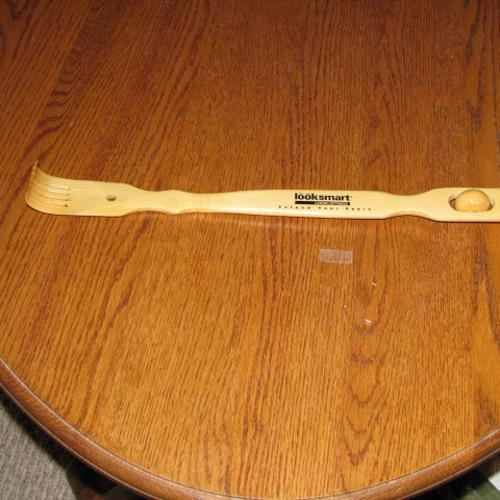

10it [00:00, 210.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

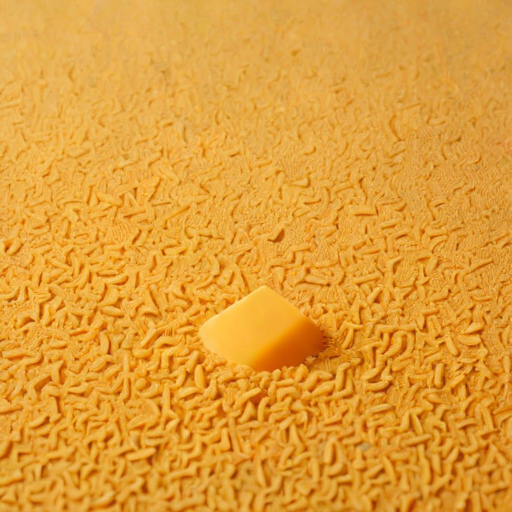

10it [00:00, 209.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

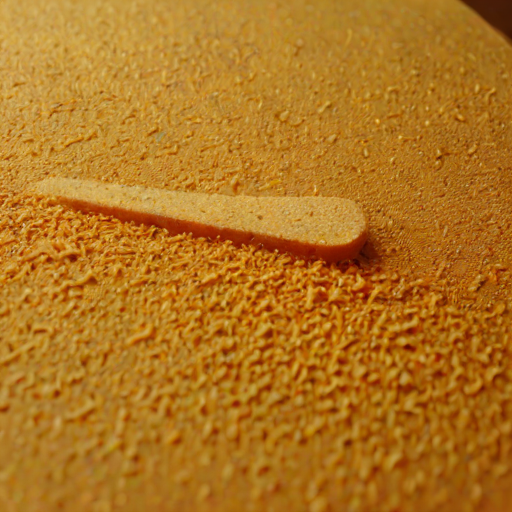

In [36]:
from IPython.display import Image, display

index = 2

# for index in range(10):
print(texts[index])
#ground truth
display(Image(filename=images[index]))

#h is the high level features generated by the eeg features -> diffusion u-net
high_level_features = pipe.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)

#Generate an image using the output of the diffusion
image = generator.generate(high_level_features, generator=gen)  
display(image)

### compare based on the old weights
#h is the high level features generated by the eeg features -> diffusion u-net
high_level_features = pipe.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)

#Generate an image using the output of the diffusion
image = generator.generate(high_level_features, generator=gen, text_prompt='Wooden back scratcher with “looksmart” logo on a wooden table.')  
display(image)

10it [00:00, 230.55it/s]
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/4 [00:00<?, ?it/s]

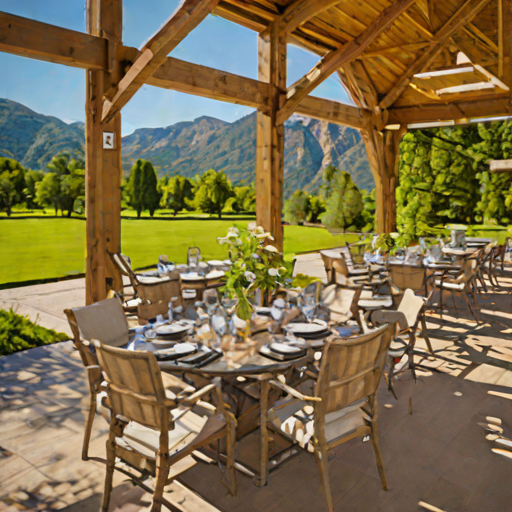

  0%|          | 0/4 [00:00<?, ?it/s]

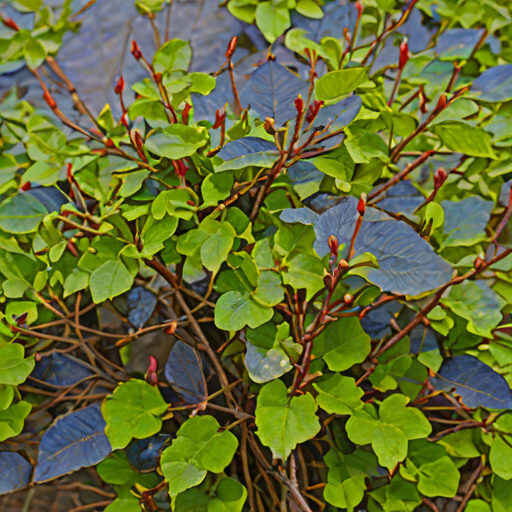

In [31]:
from IPython.display import Image, display

index = 0

#diffusion U-Net for high level features
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
pipe = Pipe(diffusion_prior, device=device)

# load pretrained model
pipe.diffusion_prior.load_state_dict(torch.load(f'/ibex/user/thagafhh/data/fintune_ckpts/sub-08/diffusion_prior.pt', map_location=device))

#h is the high level features generated by the eeg features -> diffusion u-net
high_level_features = pipe.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)

generator = Generator4Embeds(num_inference_steps=4, device=device)
# set a seed value
seed_value = 42
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

#Generate an image using the eeg embeddings 
image_1 = generator.generate(eeg_embeds[index], generator=gen)  
display(image_1)

#Generate an image using the output of the diffusion
image_2 = generator.generate(high_level_features, generator=gen)  
display(image_2)


In [23]:
# with torch.no_grad():
#     x_rec = vlmodel.decode(image_latent).sample
#     image_rec = image_processor.postprocess(x_rec, output_type='pil')
#     image_rec[0].show()

/tmp/ipykernel_2440/1867616429.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pipe.diffusion_prior.load_state_dict(torch.load(f'/root/autodl-tmp/BrainAligning/fintune_

9675648


10it [00:00, 257.29it/s]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

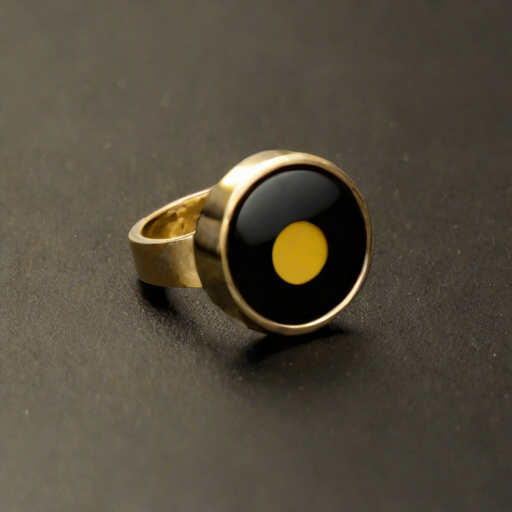

  0%|          | 0/4 [00:00<?, ?it/s]

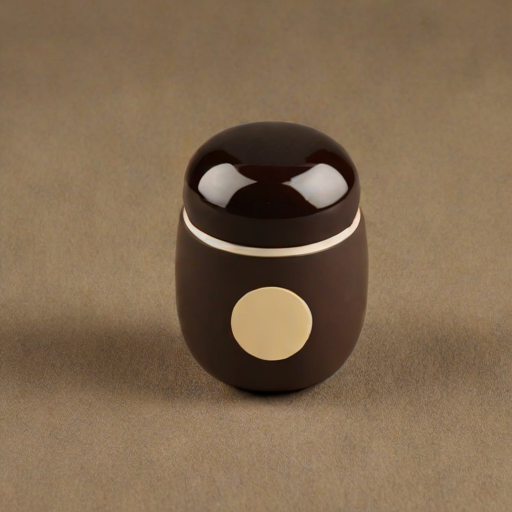

In [39]:
from IPython.display import Image, display


diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

# load pretrained model
pipe.diffusion_prior.load_state_dict(torch.load(f'/root/autodl-tmp/BrainAligning/fintune_ckpts/diffusion_prior.pt', map_location=device))
h = pipe.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)


generator = Generator4Embeds(num_inference_steps=4, device=device)
# set a seed value
seed_value = 42
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

image_1 = generator.generate(eeg_embeds[index], generator=gen)  
display(image_1)

image_2 = generator.generate(h, generator=gen)  
display(image_2)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

latents torch.Size([1, 4, 64, 64])
noise torch.Size([1, 4, 64, 64])


  0%|          | 0/10 [00:00<?, ?it/s]

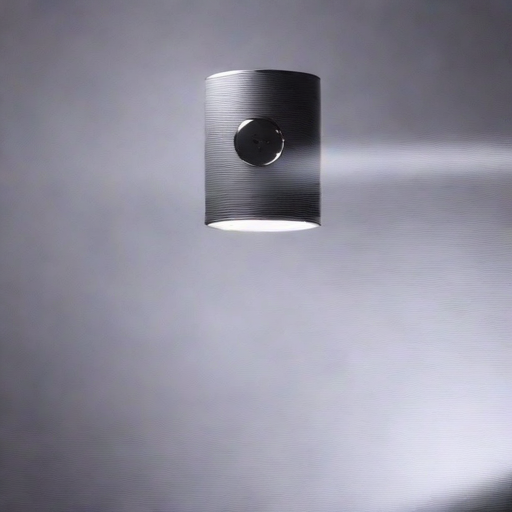

In [34]:
from IPython.display import Image, display

generator = Generator4Embeds(num_inference_steps=10, device=device, img2img_strength=0.5, low_level_image=low_level_image, low_level_latent=None)
# set a seed value
# seed_value = 30
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)
image = generator.generate(h,            
                           generator=gen)
display(image)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

latents torch.Size([1, 4, 64, 64])
noise torch.Size([1, 4, 64, 64])


  0%|          | 0/10 [00:00<?, ?it/s]

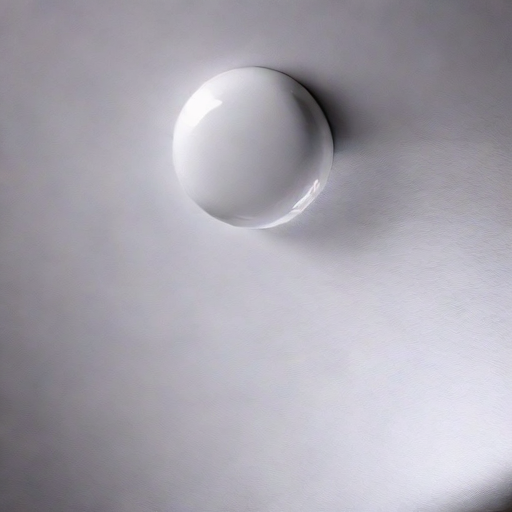

In [35]:
from IPython.display import Image, display

generator = Generator4Embeds(num_inference_steps=10, device=device, img2img_strength=0.5, low_level_image=low_level_image, low_level_latent=None)
# set a seed value
# seed_value = 30
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)
image = generator.generate(h,
                           text_prompt = "a white ceramic finish ceramic finish with a white ceramic finish.",               
                           generator=gen)
display(image)

In [36]:
# seed_value = 42
# gen = torch.Generator(device=device)
# gen.manual_seed(seed_value)
# image = generator.generate(img_feature, generator=gen)
# display(image)

In [37]:
import os
from PIL import Image
import torch
from IPython.display import display

# Assume there's a class Generator4Embeds and a clip_encoder preprocessing method
# You can modify these classes and methods based on your existing code

# Original image directory and output image directory
input_dir = '/root/autodl-tmp/BrainAligning/vae_imgs/epoch_170'
output_dir = '/root/autodl-tmp/BrainAligning/reconstructed_imgs'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Set seed value
seed_value = 42
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

# Modify sorting function to extract the number after the first "_"
def extract_number(file_name):
    # Assume the file name format is "reconstructed_image_0_2.png"
    return int(file_name.split('_')[2])  # Extract the number after the first "_"

# Iterate through all image files in the directory and sort them by the number after the first "_"
for i, file_name in enumerate(sorted(os.listdir(input_dir), key=extract_number)):
    if i % 80 == 0:
        print(file_name)            
        if file_name.endswith(".png"):  # Only process PNG images
            img_path = os.path.join(input_dir, file_name)
            
            # Open and preprocess the image
            low_level_image = Image.open(img_path)
            # low_level_image.show()
            low_level_image = clip_encoder.preprocess(low_level_image, return_tensors="pt").pixel_values  # [1, 3, 224, 224]
            
            # Create an instance of the generator
            generator = Generator4Embeds(num_inference_steps=5, device=device, img2img_strength=0.8, low_level_image=low_level_image)
            
            # Generate the reconstructed image
            reconstructed_image = generator.generate(eeg_embeds[i // 80], generator=gen)
            
            # Save the reconstructed image to the new directory
            output_path = os.path.join(output_dir, file_name)
            reconstructed_image.save(output_path)
            
            # Optionally display the generated image
            # display(reconstructed_image)

print("All images have been successfully reconstructed and saved to:", output_dir)


FileNotFoundError: [Errno 2] No such file or directory: '/root/autodl-tmp/BrainAligning/vae_imgs/epoch_40'